# ALPR using YOLO-Net as LP detector and Tesseract as OCR

## Introduction

In this notebook, we will implement Automatic License Plate Recognition (ALPR) system composed by
1. Vehicle Detection using **YOLOv2** network trained on PASCAL-VOC dataset
1. License Plate (LP) Detection using **YOLO-Net** trained on [OpenALPR benchmark](https://platerecognizer.com/number-plate-datasets/) dataset
1. Optical Character Recognition (OCR) using **Tesseract**

The ALPR implementation process involve,

1. Vehicle Detection  
```
    1.1 Download weights and config file of YOLOv2 network  trained on PASCAL-VOC dataset
    1.2 Utility functions
    1.3 Detect vehicles
```
2. License Plate Detection
```
    2.1 Download weights and config file of pretrained YOLO-Net
    2.2 Utility functions
    2.3 Detect license plates
```

3. Optical Character Recognition
```
    3.1 Install tesseract
    3.2 Recognize characters
```
4. Inference 
```
    4.1 Download the test image
    4.2 Utility functions
    4.3 Infer on the test image
    4.4 Display inference
    4.5 Observations
```

## 1. Vehicle Detection

Vehicle detection is the first step in ALPR system. Vehicles are one of the underlying objects present in many classical detection and recognition datasets, such as PASCAL-VOC, ImageNet, and COCO.

We will use pretrained YOLOv2 network trained on PASCAL-VOC dataset to perform vehicle detection. 
We will use weights and config file of YOLOv2 from [here](http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/), which is same as used by S. M. Silva an author of **License Plate Detection and Recognition in Unconstrained Scenarios**. The model was trained for 20 different object classes. The full list of class names can be found [here](http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/voc.names).

We will not perform any change or refinement to YOLOv2, just we will use the network as a black box, merging the outputs related to vehicles (i.e. cars and buses), and ignoring the other classes.





### 1.1 Download weights and config file of YOLOv2 network trained on PASCAL-VOC dataset

In [ ]:
!wget -c -N http://sergiomsilva.com/pubs/alpr-unconstrained/data/vehicle-detector/yolo-voc.cfg     -P vehicle-detector/
!wget -c -N http://sergiomsilva.com/pubs/alpr-unconstrained/data/vehicle-detector/voc.data         -P vehicle-detector/
!wget -c -N http://sergiomsilva.com/pubs/alpr-unconstrained/data/vehicle-detector/yolo-voc.weights -P vehicle-detector/
!wget -c -N http://sergiomsilva.com/pubs/alpr-unconstrained/data/vehicle-detector/voc.names        -P vehicle-detector/

### 1.2 Utility functions

Here, we define few utility functions like,
- `getOutputsNames`: Get the names of the output layers for given input neural network.
- `postprocess`: to get rid of detected bounding box with low confidence
- `drawPred:` to draw the predicted bounding box
- `crop_region:` to crop out specified region from given input image

We also define `Label` a bounding box class. All detected bounding boxs are stored as an object of this class.

In [2]:
# Get the names of the output layers
def getOutputsNames(net):
  """ Get the names of the output layers.
  
  Generally in a sequential CNN network there will be 
  only one output layer at the end. In the YOLOv3 
  architecture, there are multiple output layers giving
  out predictions. This function gives the names of the 
  output layers. An output layer is not connected to 
  any next layer.
  
  Args
    net : neural network
  """
  # Get the names of all the layers in the network
  layersNames = net.getLayerNames()
  # Get the names of the output layers, i.e. the layers with unconnected outputs
  return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

import cv2 as cv
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs, confThreshold, nmsThreshold=0.4):
  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  classIds = []
  confidences = []
  boxes = []
  # Scan through all the bounding boxes output from the network and keep only the
  # ones with high confidence scores. Assign the box's class label as the class with the highest score.
  classIds = []
  confidences = []
  boxes = []
  predictions = []

  for out in outs:
    for detection in out:
      scores = detection[5:]
      classId = np.argmax(scores)
      confidence = scores[classId]
      if confidence > confThreshold:
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        classIds.append(classId)
        confidences.append(float(confidence))
        boxes.append([left, top, width, height])

  # Perform non maximum suppression to eliminate redundant overlapping boxes with
  # lower confidences.
  if nmsThreshold:
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
  else:
    indices = [[x] for x in range(len(boxes))]

  for i in indices:
    i = i[0]
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    predictions.append([classIds[i], confidences[i], [left, top, left + width, top + height]])

  return predictions

import cv2 as cv
# Draw the predicted bounding box
def drawPred(frame, pred):
  classId = pred[0]
  conf = pred[1]
  box = pred[2]
  left, top, right, bottom =  box[0], box[1], box[2], box[3]
  # draw bounding box
  cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

import numpy as np

class Label:

	def __init__(self,cl=-1,tl=np.array([0.,0.]),br=np.array([0.,0.]),prob=None):
		self.__tl 	= tl
		self.__br 	= br
		self.__cl 	= cl
		self.__prob = prob

	def __str__(self):
		return 'Class: %d, top_left(x:%f,y:%f), bottom_right(x:%f,y:%f)' % (self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

	def copy(self):
		return Label(self.__cl,self.__tl,self.__br)

	def wh(self): return self.__br-self.__tl

	def cc(self): return self.__tl + self.wh()/2

	def tl(self): return self.__tl
 
	def br(self): return self.__br

	def tr(self): return np.array([self.__br[0],self.__tl[1]])

	def bl(self): return np.array([self.__tl[0],self.__br[1]])

	def cl(self): return self.__cl

	def area(self): return np.prod(self.wh())

	def prob(self): return self.__prob

	def set_class(self,cl):
		self.__cl = cl

	def set_tl(self,tl):
		self.__tl = tl

	def set_br(self,br):
		self.__br = br

	def set_wh(self,wh):
		cc = self.cc()
		self.__tl = cc - .5*wh
		self.__br = cc + .5*wh

	def set_prob(self,prob):
		self.__prob = prob

def crop_region(I,label,bg=0.5):

  wh = np.array(I.shape[1::-1])

  ch = I.shape[2] if len(I.shape) == 3 else 1
  tl = np.floor(label.tl()*wh).astype(int)
  br = np.ceil (label.br()*wh).astype(int)
  outwh = br-tl

  if np.prod(outwh) == 0.:
    return None

  outsize = (outwh[1],outwh[0],ch) if ch > 1 else (outwh[1],outwh[0])
  if (np.array(outsize) < 0).any():
    pause()
  Iout  = np.zeros(outsize,dtype=I.dtype) + bg

  offset  = np.minimum(tl,0)*(-1)
  tl      = np.maximum(tl,0)
  br      = np.minimum(br,wh)
  wh      = br - tl

  Iout[offset[1]:(offset[1] + wh[1]),offset[0]:(offset[0] + wh[0])] = I[tl[1]:br[1],tl[0]:br[0]]

  return Iout

### 1.3 Detect vehicles

Let's define the `vehicle_detection` function which takes an image as input and return `Icars` list of cropped images of vehicles as well as `Lcars` list of bouding box around vehicles. 

We use `postprocess` utility function to get rid of detected bounding box with low confidence. The `postprocess` utility function internally uses `cv.dnn.NMSBoxes` which perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences. We keep only those bounding boxs whose corresponding `classId` is either `car` (class number 6) or `bus` (class number 7), since this two `classId` are related to vehicles.

We will use `vehicle_detection` function as first step in our ALPR system implementation. 

In [3]:
# Import necessary modules
import cv2 as cv
import numpy as np

# Initialize the parameters
vehicle_threshold = .5
vehicle_weights = 'vehicle-detector/yolo-voc.weights'
vehicle_netcfg  = 'vehicle-detector/yolo-voc.cfg'

# Load the model
vehicle_net = cv.dnn.readNetFromDarknet(vehicle_netcfg, vehicle_weights)
vehicle_net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
vehicle_net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

def vehicle_detection(frame):

  # Create a 4D blob from a frame.
  blob = cv.dnn.blobFromImage(frame, 1/255, (416, 416), [0,0,0], 1, crop=False)

  # Sets the input to the network
  vehicle_net.setInput(blob)

  # Runs the forward pass to get output of the output layers
  outs = vehicle_net.forward(getOutputsNames(vehicle_net))

  # Remove the bounding boxes with low confidence
  R = postprocess(frame, outs, vehicle_threshold)
  
  Icars = []
  Lcars = []

  if len(R):
    WH = np.array(frame.shape[1::-1], dtype=float)
    for i, r in enumerate(R):
      # if classId in ['car', 'bus'] and confidence > vehicle_threshold
      if r[0] in [6, 7] and r[1] > vehicle_threshold:
        box = r[2]
        x1,y1,x2,y2 = (np.array(r[2])/np.concatenate((WH,WH))).tolist()
        tl = np.array([x1, y1])
        br = np.array([x2, y2])
        label = Label(0,tl,br)
        Lcars.append(label)
        Icar = crop_region(frame,label)
        Icars.append(Icar.astype(np.uint8))

  return Icars, Lcars 

## 2. License Plate Detection

License Plate Detection is the second step in ALPR system. For each detected vehicle in the first step, we apply this second step to detect region of license plate in detected vehicle region.

We will use YOLO-Net - a YOLOv3 Network trained in previous notebook, for LP detection. 

### 2.1 Download weights and config file of pretrained YOLO-Net

In [ ]:
!wget -c -N https://www.dropbox.com/s/vw9omi6tjntp6vr/yolov3-LP-train_best.weights     -P lp-detector/
!wget -c -N https://www.dropbox.com/sh/5y72h8ul8654y9i/AAAFwOwOl7bsQ4BmuxraKBRta?dl=0  -O lp-detector/yolov3_LP.zip
%cd lp-detector
!unzip yolov3_LP.zip
%cd ..

### 2.2 Detect license plates

Let's define a `lp_detection` function which takes vehicle image as input and return `Llps` list of bounding boxs around detected license plates and `Ilps` list of croppsed images of detected license plates.

Again, we use `postprocess` utility function to remove bouding box with low threshold.  

In [5]:
# Import necessary modules
import cv2 as cv
import numpy as np
import time

# Initialize the parameters
lp_threshold = .6
yolo_lp_confi_path = 'lp-detector/yolov3-LP-test.cfg'
yolo_lp_weights_path = 'lp-detector/yolov3-LP-train_best.weights'

# load the network
lp_net = cv.dnn.readNetFromDarknet(yolo_lp_confi_path, yolo_lp_weights_path)
lp_net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
lp_net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

def lp_detection(vehicle_img):
  # Create a 4D blob from a frame.
  blob = cv.dnn.blobFromImage(vehicle_img, 1/255, (416, 416), [0,0,0], 1, crop=False)
  # Sets the input to the network
  lp_net.setInput(blob)
  # Runs the forward pass to get output of the output layers
  start 	= time.time()
  outs = lp_net.forward(getOutputsNames(lp_net))
  elapsed = time.time() - start
  # Remove the bounding boxes with low confidence
  R = postprocess(vehicle_img, outs, lp_threshold)

  Llps = []
  Ilps = []

  if len(R):
    WH = np.array(vehicle_img.shape[1::-1], dtype=float)
    for i, r in enumerate(R):
      if r[1] > lp_threshold:
        box = r[2]
        x1,y1,x2,y2 = (np.array(r[2])/np.concatenate((WH,WH))).tolist()
        tl = np.array([x1, y1])
        br = np.array([x2, y2])
        label = Label(0,tl,br)
        Llps.append(label)
        Ilp = crop_region(vehicle_img,label)
        Ilps.append(Ilp.astype(np.uint8))

  return Llps, Ilps, elapsed

## 3. Optical Character Recognition

OCR is third and last step in ALPR system. In this step, for each detected license plate we apply OCR for a) character segmentation and b) character recognition.

We will use tesseract OCR engine for recognizing and converting text of license plate into machine-encoded string. 

### 3.1 Install tesseract

[Tesseract](https://github.com/tesseract-ocr/tesseract) is an optical character recognition (OCR) engine. That is, it will recognize and “read” the text embedded in images.

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract 

### 3.2 Recognize characters

Let's define a `lp_ocr` function which takes image of license plate as input, apply tesseract OCR engine, converts license plate text into string and return that string as output. 

In [7]:
# Import necessary modules
import cv2 as cv
import pytesseract

def lp_ocr(lp_img):
  gray_lp_img = cv.cvtColor(lp_img, cv.COLOR_BGR2GRAY)
  lp_str = pytesseract.image_to_string(gray_lp_img, config=("-l eng --oem 1 --psm 13"))    
  return lp_str

## 4. Inference



We have already defined 1) `vehicle_detection` 2) `lp_detection` and 3) `lp_ocr` to perform vehicle detection, license plate detection and OCR respectively. 

Let's implement our ALPR systen which is compised all these three function in a sequential pipeline. 

### 4.1 Download the test image

In [ ]:
!wget "https://raw.githubusercontent.com/sergiomsilva/alpr-unconstrained/master/samples/test/03066.jpg" -O test_img.jpg

### 4.2 Utility functions

Here, we define few utility functions like,
- `draw_label`: to draw bounding box using object of `Label` class as input
- `draw_losangle`: to draw bouding box using a set of four corner points.
- `write2img`: to write text on a input image around given bounding box. 

In [9]:
import numpy as np
import cv2 as cv

def draw_label(I,l,color=(255,0,0),thickness=1):
	wh = np.array(I.shape[1::-1]).astype(float)
	tl = tuple((l.tl()*wh).astype(int).tolist())
	br = tuple((l.br()*wh).astype(int).tolist())
	cv.rectangle(I,tl,br,color,thickness=thickness)

def draw_losangle(I,pts,color=(1.,1.,1.),thickness=1):
	assert(pts.shape[0] == 2 and pts.shape[1] == 4)

	for i in range(4):
		pt1 = tuple(pts[:,i].astype(int).tolist())
		pt2 = tuple(pts[:,(i+1)%4].astype(int).tolist())
		cv.line(I,pt1,pt2,color,thickness)

def write2img(Img,label,strg,txt_color=(0,0,0),bg_color=(255,255,255),font_size=1):
	wh_img = np.array(Img.shape[1::-1])

	font = cv.FONT_HERSHEY_SIMPLEX

	wh_text,v = cv.getTextSize(strg, font, font_size, 3)
	bl_corner = label.tl()*wh_img

	tl_corner = np.array([bl_corner[0],bl_corner[1]-wh_text[1]])/wh_img
	br_corner = np.array([bl_corner[0]+wh_text[0],bl_corner[1]])/wh_img
	bl_corner /= wh_img

	if (tl_corner < 0.).any():
		delta = 0. - np.minimum(tl_corner,0.)
	elif (br_corner > 1.).any():
		delta = 1. - np.maximum(br_corner,1.)
	else:
		delta = 0.

	tl_corner += delta
	br_corner += delta
	bl_corner += delta

	tpl = lambda x: tuple((x*wh_img).astype(int).tolist())

	cv.rectangle(Img, tpl(tl_corner), tpl(br_corner), bg_color, -1)	
	cv.putText(Img,strg,tpl(bl_corner),font,font_size,txt_color,3)

### 4.3 Infer on the test image


To infer on the test image we apply
- first, `vehicle_detection` to detect all vehicles in an input test image. Output of this step is `Icars` a list of cropped vehicles regions as well as `Lcars` a list of bounding boxs around detected vehicles.

- second, `lp_detection` on each cropped vehicle regions in `Icars` to detect license plates. Output of this step is `Llps` a list of bouding boxs around detected license plate as well as `Ilps` cropped images of license plate in given vehicle image.

- third, `lo_ocr` on each cropped license plate region in `Ilps` to convert licese plat text in it to a string.

- finally, `write2img` to write recognized license plat charactes on the input test image.




In [10]:
# Import necessary modules
import numpy as np
import cv2 as cv
# read test image
test_img = cv.imread('test_img.jpg')
# detect cars
Icars, Lcars = vehicle_detection(test_img)
print('# vehicle detected: {}'.format(len(Icars)))
# for each detected car in test image
for Icar, Lcar in zip(Icars, Lcars):
  # draw car bounding box on test image
  draw_label(test_img,Lcar,color=(0,255,255),thickness=3)
  # detect LP in detected car
  Llps, Ilps, elapsed = lp_detection(Icar)   
  # for each detected LP in the detected car image
  for Llp, Ilp in zip(Llps, Ilps):
    # draw LP bounding box on test image
    tl = Llp.tl() * Lcar.wh() + Lcar.tl()
    br = Llp.br() * Lcar.wh() + Lcar.tl()
    draw_label(test_img,Label(0,tl,br),color=(255,0,0),thickness=3)
    # Recognize characters
    lp_str = lp_ocr(Ilp)
    # write text on test image
    write2img(test_img,Label(0,tl,br),lp_str)

# vehicle detected: 3


### 4.4 Display inference

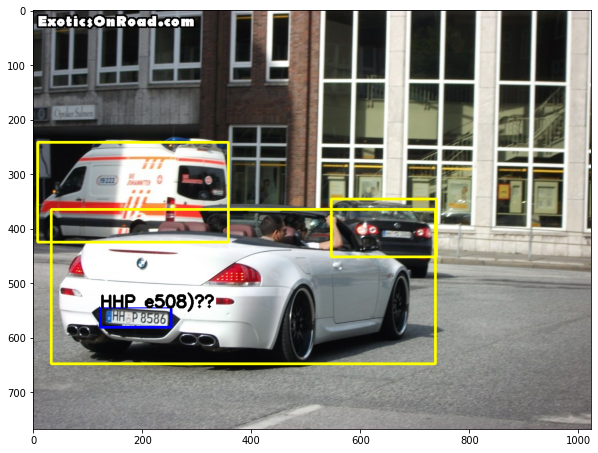

In [11]:
# Import necessary modules
import matplotlib
import matplotlib.pyplot as plt
# Display inference
fig=plt.figure(figsize=(10, 10))
plt.imshow(test_img[:,:,::-1])
plt.show()

### 4.5 Observations

From the above result we can make following observations,

- LP detection using YOLO-Net gives planer rectangular bounding box around license plate even if it is oblique. Relaxed image acquisition scenarios might lead to oblique views in which the LP might be highly distorted and eventually may degrade overall OCR performance.

- The performance of OCR is not satisfactory. Note that tesseract is generic OCR engine which is not trained specific to license plate. Text in license plate has specific properties like 1) it does not contain special character (i.e., @, %, etc.) and 2) it follows specific pattern of letters and numbers.

In next notebook, we will use **Modified YOLO** as OCR to improve the performance of ALPR system. Modified YOLO is trained specially for license plate scenarios. 